In [1]:
!pip install opencv-python opencv-python-headless face_recognition numpy tensorflow opencv-python opencv-python-headless mtcnn

  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/ac/42/da433fca5733a3ce7e88dd0d4018f70dcffaf48770b5142250815f4faddb/opencv_python_headless-4.9.0.80-cp37-abi3-macosx_10_16_x86_64.whl.metadata
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-macosx_10_16_x86_64.whl.metadata (20 kB)
  Obtaining dependency information for face_recognition from https://files.pythonhosted.org/packages/1e/95/f6c9330f54ab07bfa032bf3715c12455a381083125d8880c43cbe76bb3d0/face_recognition-1.3.0-py2.py3-none-any.whl.metadata
  Using cached face_recognition-1.3.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached face_recognition_models-0.3.0-py2.py3-none-any.whl
  Using cached dlib-19.24.4.tar.gz (3.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached opencv_python_headless-4.9.0.80-cp37-abi3-macosx_10_16_x86_64.whl (55.7 MB)
Using cached face_reco

In [3]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/35/69/b657974ddcbba54d59d7d62b01e60a8b815e35f415b996e4d355be0ac7b4/opencv_python-4.9.0.80-cp37-abi3-macosx_10_16_x86_64.whl.metadata
  Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_10_16_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_10_16_x86_64.whl (55.7 MB)


In [2]:
!pip install mtcnn
!pip install tensorflow

In [3]:
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as image_utils
from keras.applications import InceptionResNetV2

2024-04-18 14:09:03.662846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
face_recognition_model = InceptionResNetV2(weights='imagenet', include_top=False)

In [5]:
def preprocess_image(image_path):
    img = image_utils.load_img(image_path, target_size=(160, 160))
    img_array = image_utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 127.5 - 1.0
    return img_array

def preprocess_face(face):
    face = cv2.resize(face, (160, 160))
    face = face.astype("float32")
    face = (face - 127.5) / 128
    face = np.expand_dims(face, axis=0)
    return face

def load_known_faces(names, image_paths, face_recognition_model):
    known_face_encodings = []
    for path in image_paths:
        img_array = preprocess_image(path)
        face_encoding = face_recognition_model.predict(img_array)[0]
        known_face_encodings.append(face_encoding)
    return dict(zip(names, known_face_encodings))


def detect_faces(image, face_recognition_model):
    # Detect faces in the image using MTCNN
    face_detector = MTCNN()
    face_locations = face_detector.detect_faces(image)
    face_locations = [(face['box'][1], face['box'][0] + face['box'][2], face['box'][1] + face['box'][3], face['box'][0]) for face in face_locations]
    return face_locations

def encode_faces(image, face_locations, face_recognition_model):
    face_encodings = []
    for (top, right, bottom, left) in face_locations:
        face = image[top:bottom, left:right]
        face = cv2.resize(face, (160, 160))
        face = face.astype("float32")
        face = (face - 127.5) / 128
        face = np.expand_dims(face, axis=0)
        face_encoding = face_recognition_model.predict(face)[0]
        face_encodings.append(face_encoding)
    return face_encodings


def recognize_faces(image_path, known_faces, face_recognition_model, tolerance=70):
    recognized_names = []
    recognized_face_locations = []

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    face_locations = detect_faces(image, face_recognition_model)
    face_encodings = encode_faces(image, face_locations, face_recognition_model)

    for face_encoding, face_location in zip(face_encodings, face_locations):
        distances = {name: np.linalg.norm(encoding - face_encoding) for name, encoding in known_faces.items()}
        print(f"Distances for face at {face_location}: {distances}")  # Print distances

        min_distance_name = min(distances, key=distances.get)
        min_distance = distances[min_distance_name]

        # Check if the minimum distance is within the tolerance value
        if min_distance <= tolerance:
            name = min_distance_name
        else:
            name = "Unknown"

        recognized_names.append(name)
        recognized_face_locations.append(face_location)

    return recognized_names, recognized_face_locations

import os

def create_known_faces_database(people_names, people_image_folders, face_recognition_model):
    known_faces = {}
    for i, name in enumerate(people_names):
        print(f"Processing images of {name}")
        images_folder = people_image_folders[i]
        face_encodings = []
        for filename in os.listdir(images_folder):
            image_path = os.path.join(images_folder, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            face_locations = detect_faces(image, face_recognition_model)
            for face_location in face_locations:
                top, right, bottom, left = face_location
                face = image[top:bottom, left:right]
                face = preprocess_face(face)
                face_encoding = face_recognition_model.predict(face)[0]
                face_encodings.append(face_encoding)
        known_faces[name] = np.mean(face_encodings, axis=0)
    return known_faces


def draw_boxes(image, recognized_names, recognized_face_locations):
    for (top, right, bottom, left), name in zip(recognized_face_locations, recognized_names):
        cv2.rectangle(image, (left, top), (right, bottom), (0, 0, 255), 2)
        font = cv2.FONT_HERSHEY_DUPLEX
        label = f"{name} ({left}, {top})"
        cv2.putText(image, label, (left + 6, bottom - 6), font, 0.5, (255, 255, 255), 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image



In [6]:
if __name__ == '__main__':


  people_names = ['Jay', 'Rishi']
  person1_image_folder = '/Users/superadmin/Downloads/database/Jay'
  person2_image_folder = '/Users/superadmin/Downloads/database/Rishi'


  people_image_paths = [person1_image_folder, person2_image_folder]

  known_faces = create_known_faces_database(people_names, people_image_paths, face_recognition_model)


Processing images of Jay
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Distances for face at (136, 423, 429, 188): {'Jay': 94.694145, 'Rishi': 58.59103}
['Rishi']


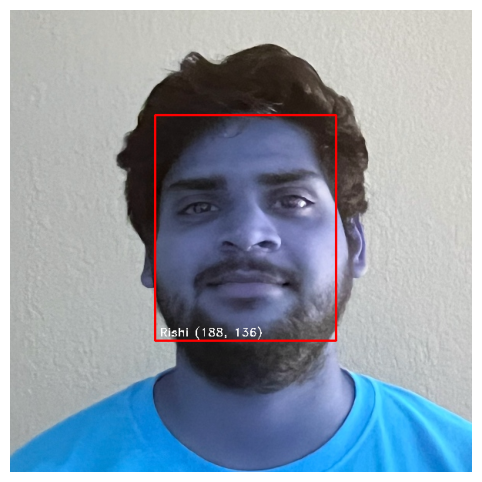

In [7]:
from matplotlib import pyplot as plt
if __name__ == '__main__':

    #Test Image Path
    image_path = "/Users/superadmin/Downloads/database/Test/cropped-IMG_4144.jpg"

    recognized_names, recognized_face_locations = recognize_faces(image_path, known_faces, face_recognition_model)

    print(recognized_names)

    # Load the image again to draw the bounding boxes
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes on the image
    image_with_boxes = draw_boxes(image, recognized_names, recognized_face_locations)

    # Display the image with bounding boxes
    # Use matplotlib to display the image with bounding boxes
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.imshow(image_with_boxes)
    plt.axis('off')  # Hide axes ticks
    plt.show()

In [ ]:
import cv2

# Start video capture
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()

print("Press 's' to capture the image and 'q' to quit without capturing.")

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    # Display the resulting frame
    cv2.imshow('Camera Feed', frame)

    # Define the key to take a snapshot or quit
    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):
        img = frame
        print("Image captured!")
        break
    elif key == ord('q'):
        print("Exiting without capturing.")
        break

# Release the capture and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

# img now holds the captured image; you can process it further
# Example of verifying the captured image shape
if 'img' in locals():
    print("Captured image shape:", img.shape)

Cannot open camera
Press 's' to capture the image and 'q' to quit without capturing.
Can't receive frame (stream end?). Exiting ...


OpenCV: not authorized to capture video (status 0), requesting...
OpenCV: camera failed to properly initialize!


In [ ]:
from matplotlib import pyplot as plt
if __name__ == '__main__':

    #Test Image Path
    image_path = "/Users/superadmin/Downloads/database/Test/Russian_passport_photo.jpeg"

    recognized_names, recognized_face_locations = recognize_faces(image_path, known_faces, face_recognition_model)

    print(recognized_names)

    # Load the image again to draw the bounding boxes
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes on the image
    image_with_boxes = draw_boxes(image, recognized_names, recognized_face_locations)

    # Display the image with bounding boxes
    # Use matplotlib to display the image with bounding boxes
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.imshow(image_with_boxes)
    plt.axis('off')  # Hide axes ticks
    plt.show()